# Reconocimiento de la edad de clientes

Proyecto desarrollado para la cadena de supermercados Good Seed con el objetivo de apoyar mediante técnicas de ciencia de datos en el cumplimiento de la normativa al asegurarse de no vender alcohol a personas menores de edad. 

El proyecto consiste en utilizar métodos de visión artificial para la construcción y evaluación de un modelo destinado al reconocimiento de la edad de los clientes. Para dicha tarea, se utiliza un conjunto de fotografías de personas y su edad.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Inicialización](#toc1_)    
- [Carga de datos](#toc2_)    
- [Análisis exploratorio de datos](#toc3_)    
  - [Distribución de edad en el conjunto de datos](#toc3_1_)    
  - [Visualización de muestra de imágenes del conjunto](#toc3_2_)    
  - [Conclusiones del análisis exploratorio](#toc3_3_)    
- [Modelado](#toc4_)    
  - [Funciones](#toc4_1_)    
  - [Script para la ejecución en la plataforma GPU](#toc4_2_)    
  - [Resultado del modelo](#toc4_3_)    
- [Conclusiones generales](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Inicialización](#toc0_)

In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

## <a id='toc2_'></a>[Carga de datos](#toc0_)

El conjunto de datos se almacena en la carpeta `/datasets/faces/`, en donde se encuentra:
- La carpeta `final_files` que contiene 7600 fotos
- El archivo `labels.csv` con el nombre de las fotos de personas y su edad, distribuidos en las columnas `file_name` y `real_age` respectivamente.

Dado que el número de archivos de imágenes es bastante elevado, se evita leerlos todos a la vez. En su lugar, se crea un generador con ImageDataGenerator.

In [2]:
# Lectura del archivo.csv
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [16]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [36]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [26]:
# Generador de datos
datagen = ImageDataGenerator() 

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    seed=12345
)

Found 7591 validated image filenames.


In [38]:
# Revisión de duplicados
print('Número de duplicados:',labels.duplicated().sum())

Número de duplicados: 0


El número de filas de `labels` coincide con la cantidad de imágenes validadas por el generados de datos. Por otro lado, nos aseguramos de que no existen valores ausentes y duplicados entre los archivos.

## <a id='toc3_'></a>[Análisis exploratorio de datos](#toc0_)

### <a id='toc3_1_'></a>[Distribución de edad en el conjunto de datos](#toc0_)

In [39]:
# Estadística descriptiva de labels
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

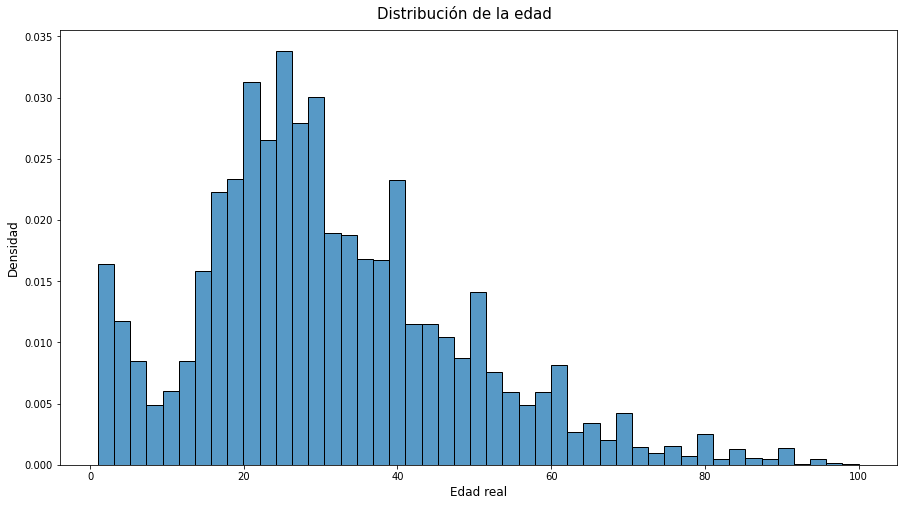

In [41]:
# histograma de los datos de edad
fig = plt.figure(figsize=(15, 8))
plt.suptitle('Distribución de la edad', fontsize=15, y=.92)
sns.histplot(labels['real_age'], kde=False, stat="density", linewidth=1)
plt.xlabel('Edad real', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

In [53]:
# Obtener proporciones por grupo de edad
under18_count = labels[labels['real_age'] < 18]['file_name'].count()
under21_count = labels[labels['real_age'] < 21]['file_name'].count()
print(f'Porcentaje de personas menores de 18 años: {under18_count / len(labels):.2%}')
print(f'Porcentaje de personas menores de 21 años: {under21_count / len(labels):.2%}')

Porcentaje de personas menores de 18 años: 19.80%
Porcentaje de personas menores de 21 años: 27.06%


### <a id='toc3_2_'></a>[Visualización de muestra de imágenes del conjunto](#toc0_)

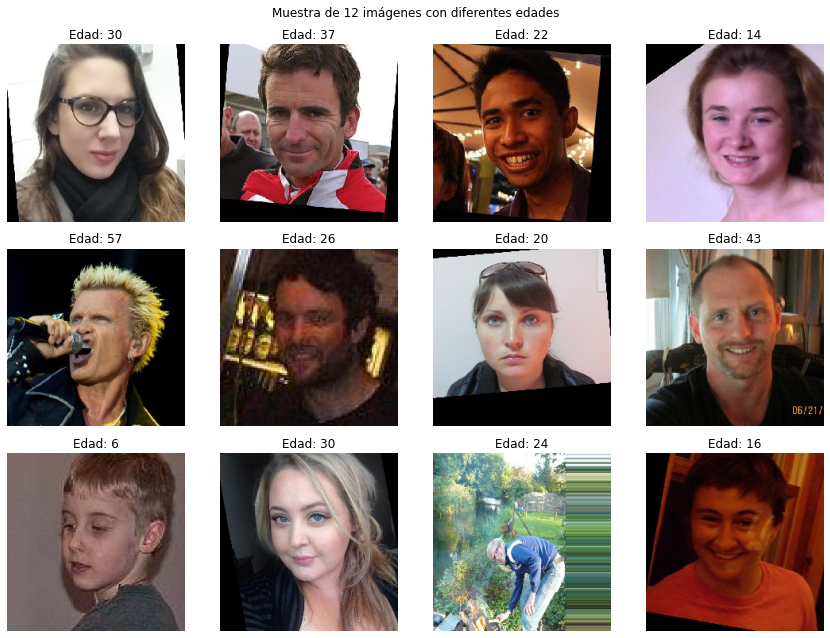

In [33]:
# Visualización de una muestra del conjunto de fotografías de las personas con su edad
sample_df = labels.sample(12)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Muestra de 12 imágenes con diferentes edades')

for i, ax in enumerate(axes.ravel()):
    if i < len(sample_df):
        img_path = os.path.join('/datasets/faces/final_files/', sample_df.iloc[i]['file_name'])
        img = load_img(img_path, target_size=(224, 224))
        ax.imshow(img)
        ax.set_title(f'Edad: {sample_df.iloc[i]["real_age"]}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### <a id='toc3_3_'></a>[Conclusiones del análisis exploratorio](#toc0_)

El conjunto se compone de fotografías de personas de edades entre 1 y 100 años, donde la mayoría de personas se ubica en el 
rango de los 20 y 35 años de edad, siendo el promedio 31 años.

Existe una cantidad importante de fotografías de edades entre 1 y 10 años, lo cual aleja al conjunto de una distribución normal. 
Adicionalmente, existe un ligero sesgo del conjunto hacia la derecha. 

La cantidad de personas menores de 18 años corresponde a casi el 20% del conjunto, mientras que los menores de 21 son el 27%.
Aunque se desconoce cuál es la edad legal en este caso, se considera que las personas menores de edad están adecuadamente
representadas en este conjunto de datos.

Finalmente, se obtuvo una muestra de fotografías junto con la edad de la persona, lo que indica que el generador de datos
funciona correctamente. Se observa, adicionalmente, distintas variaciones en las fotografías en cuanto a la iluminación, resolución, composición del fondo, posición del rostro de la persona, entre otros. Si bien, esto da cuenta de la diversidad de las fotografías de las cuales el modelo puede aprender, también puede ser un factor que afecte el desempeño del modelo en casos donde la calidad de la imagen esté muy comprometida, tal puede ser el caso de la segunda imagen de la segunda fila (de izq. a der.) o la tercera imagen de la tercera fila.

## <a id='toc4_'></a>[Modelado](#toc0_)

### <a id='toc4_1_'></a>[Funciones](#toc0_)

En este sección, se definen las funciones necesarias para entrenar el modelo en la plataforma GPU, las cuales consisten en:
1. Carga de datos de entrenamiento
2. Carga de datos de validación/testeo
3. Creación del modelo
4. Entrenamiento del modelo

In [ ]:
# Carga de datos de entrenamiento
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True) 
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory= path + 'final_files/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        x_col='file_name',
        y_col='real_age',
        seed=12345
    )
    return train_datagen_flow

In [ ]:
# Función para cargar los datos de validación o testeo
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.) 
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory= path + 'final_files/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        x_col='file_name',
        y_col='real_age',
        seed=12345
    )
    return test_datagen_flow

In [ ]:
# Función de creación del modelo
def create_model(input_shape):
    
    """
    Define el modelo
    """
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='relu'))  
    model.compile(optimizer=Adam(lr=.0001), loss='mae', metrics=['mae'])

    return model

In [ ]:
# Función de entrenamiento del modelo
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo con los parámetros dados
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

### <a id='toc4_2_'></a>[Script para la ejecución en la plataforma GPU](#toc0_)

Una vez definidas las funciones necesarias, se redacta un script para ejecutar el modelo en la plataforma GPU. Los resultados se incluirán en una celda markdown para su posterior evaluación.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### <a id='toc4_3_'></a>[Resultado del modelo](#toc0_)

Las funciones para el modelado se definieron de tal manera que en la carga de datos de entrenamiento y testo se cargaron las imágenes con en el generador de datos en lotes de 16, se redujo el tamaño de pizeles a 150x150 y, adicionalmente, se especificó un volteo horizontal como parámetro de aumento de imágenes. 

En la función de creación del modelo, se especificó que el modelo utilizaría la arquitectura ResNet50 como base. Los pesos utilizados son los preentrenados en el conjunto de datos de ImageNet y se excluyeron las top layers de la red para agregar capas que se adapten a la tarea de regresión. Por tal motivo, en la capa de salida se utilizó una capa densa con una neurona y función de activación ReLU para predecir una única salida numérica. Al compilar del modelo, se utilizó el optimizador Adam con una tasa de aprendizaje de 0.0001 y el Mean Absolute Error (MAE) tanto para la métrica como para la función de pérdida del modelo. 

Finalmente, el modelo se entrenó con 10 épocas para evitar un prolongado consumo de tiempo y recursos computacionales. El output del modelo incluye el MAE de entrenamiento y validación para cada época, y se muestra a continuación:

<font color="blue">

Train for 356 steps, validate for 119 steps

Epoch 1/10

2023-09-27 03:38:42.642369: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-09-27 03:38:43.603717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 57s - loss: 10.9310 - mae: 10.9312 - val_loss: 19.4942 - val_mae: 19.4914

Epoch 2/10

356/356 - 37s - loss: 7.6100 - mae: 7.6100 - val_loss: 9.9252 - val_mae: 9.9296

Epoch 3/10

356/356 - 37s - loss: 6.7643 - mae: 6.7647 - val_loss: 7.5237 - val_mae: 7.5228

Epoch 4/10

356/356 - 37s - loss: 6.0127 - mae: 6.0132 - val_loss: 6.5847 - val_mae: 6.5810

Epoch 5/10

356/356 - 37s - loss: 5.2529 - mae: 5.2537 - val_loss: 7.2685 - val_mae: 7.2634

Epoch 6/10

356/356 - 37s - loss: 4.8218 - mae: 4.8220 - val_loss: 6.5660 - val_mae: 6.5631

Epoch 7/10

356/356 - 37s - loss: 4.4877 - mae: 4.4882 - val_loss: 6.6613 - val_mae: 6.6624

Epoch 8/10

356/356 - 37s - loss: 4.0753 - mae: 4.0752 - val_loss: 6.4575 - val_mae: 6.4521

Epoch 9/10

356/356 - 37s - loss: 3.9223 - mae: 3.9223 - val_loss: 6.5666 - val_mae: 6.5723

Epoch 10/10

356/356 - 37s - loss: 3.6366 - mae: 3.6367 - val_loss: 6.3897 - val_mae: 6.3818

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to

  ['...']

119/119 - 9s - loss: 6.3897 - mae: 6.3818

Test MAE: 6.3818

</font>

## <a id='toc5_'></a>[Conclusiones generales](#toc0_)

Este proyecto tuvo como objetivo la construcción y evaluación de un modelo para la cadena Good Seed destinado al reconocimiento de la edad de los clientes con un MAE no mayor a 8. Previo al desarrollo del modelo, se realizó un análisis exploratorio de los datos para conocer la distribución de la edad de los clientes y la calidad de las imágenes. Se encontró que la mayoría de edades se ubica entre los 20 y 35, mientras que la edad promedio es de 31 años. El grupo de personas que está por debajo de la edad legal para consumir alcohol corresponde al 20-27% del conjunto dependiendo si esa edad es 18 o 21 años, en cualquier caso, se considera que el grupo está adecuadamente representado. Por otro lado, el conjunto de imágenes muestra ser diverso en cuanto a aspectos como iluminación, resolución, composición y posición del rostro, lo cual puede ser positivo para el aprendizaje pero también afectar el desempeño si la calidad de determinadas imágenes resulta estar muy comprometida. 

El modelo se desarrolló tomando como base la arquitectura ResNet50 con capas personalizadas para adaptarse a la tarea de regresión. Se utilizó el optimizador Adam con un tasa de aprendizaje de 0.0001 y se entrenó el modelo con 10 épocas para alcanzar un tiempo óptimo de entrenamiento. El rendimiento mostró un MAE 6.38 en el conjunto de validación, el cual es un valor aceptable y cumple con el requerimiento de la compañía. Pese a este resultado, se recomienda estudiar la representación de edades en los datos y la calidad de las imágenes con el objeto de conocer su impacto en el entrenamiento del modelo. Alternativamente, se sugiere seguir experimentando con diferentes configuraciones de hiperparámetros para lograr mejorar el rendimiento.